# 3-1. 프로젝트 - Movielens 영화 SBR

이번에 우리는 Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작해 보겠습니다.


[루브릭]

1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.	
    - 데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.
    
    
2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다. 
    - 적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.
    
    
3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.	
    - 3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.

In [1]:
# 우선 주요 라이브러리 버전을 확인해 보죠.

import pandas as pd
import tensorflow as tf

print(pd.__version__)
print(tf.__version__)

1.3.3
2.6.0


In [ ]:
# # 1) 데이터 확인
# ! ls -l ~/data

# # 2) 프로젝트 폴더 생성
# ! mkdir -p ~/aiffel/17_recommender_system/yoochoose

# # 3) 프로젝트 폴더로 데이터 폴더 링크 연결
# ! ln -s ~/data/* ~/aiffel/17_recommender_system/yoochoose/data

In [1]:
import datetime as dt
from pathlib import Path
import os
import time
from datetime import datetime
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME') + '/aiffel/17_recommender_system/yoochoose/data/')
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0,1,2,3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


여기서 이전 실습 내역과 가장 크게 다른 부분은 

1. 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 
    - 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 
    - 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

2. Rating 정보가 포함되어 있습니다. 
    - 이전 실습 내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 
    - 하지만, 직전에 봤던 영화가 맘에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 
    - 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

3. Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있습니다.


위와 같은 정보를 바탕으로 오늘의 실습과정과 유사한 프로젝트 과정을 진행해 보겠습니다.

In [3]:
# Convert Time to readable format for analysis
data['Time'] = pd.to_datetime(data['Time'], unit='s')
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [4]:
# Check for basic statistics
print(f"Number of unique users: {data['UserId'].nunique()}")
print(f"Number of unique movies: {data['ItemId'].nunique()}")
print(f"Rating distribution:\n{data['Rating'].value_counts()}")
print(f"Time range: {data['Time'].min()} to {data['Time'].max()}")

Number of unique users: 6040
Number of unique movies: 3706
Rating distribution:
4    348971
3    261197
5    226310
2    107557
1     56174
Name: Rating, dtype: int64
Time range: 2000-04-25 23:05:32 to 2003-02-28 17:49:50


## Step 1. 데이터의 전처리
위와 같이 간단히 구성해 본 데이터셋을 꼼꼼히 살펴보면서 
- 항목별 기본 분석, 
- session length, 
- session time, 
- cleaning 등의 작업을 진행합니다.

특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

### 1-1. UserId

- 유저당 본 영화 수는 중앙값이 96편, 평균이 166편
- 최소는 20편, 최대는 2314편
    - 0.999 분위수는 1323편
    - 'UserId' 4169가 본 것은 outlier로 제외

In [5]:
films_per_user = data.groupby('UserId').size().reset_index(name='Films Watched')
films_per_user = films_per_user.sort_values(by='Films Watched', ascending=False)
films_per_user

,UserId,Films Watched
4168,4169,2314
1679,1680,1850
4276,4277,1743
1940,1941,1595
1180,1181,1521
...,...,...
5724,5725,20
3406,3407,20
1663,1664,20
4418,4419,20


In [6]:
films_per_user['Films Watched'].median(), films_per_user['Films Watched'].mean()

(96.0, 165.5975165562914)

In [7]:
films_per_user['Films Watched'].min(), films_per_user['Films Watched'].max()

(20, 2314)

In [8]:
films_per_user['Films Watched'].quantile(0.99)

906.659999999998

In [9]:
per_user_count = films_per_user.groupby('Films Watched').size()
per_user_count_cumsum = per_user_count.cumsum() / per_user_count.sum()
per_user_count_cumsum_999 = per_user_count_cumsum[per_user_count_cumsum < 0.999]

per_user_count_cumsum_999

Films Watched
20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

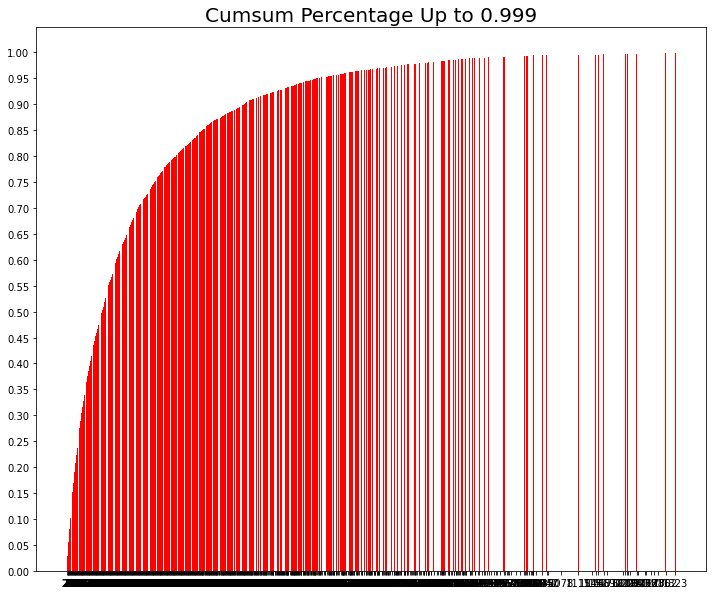

In [10]:
plt.figure(figsize=(12, 10))
plt.bar(x=per_user_count_cumsum_999.index,
        height=per_user_count_cumsum_999, color='red')
plt.xticks(per_user_count_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Up to 0.999', size=20)
plt.show()

In [11]:
data = data.loc[data['UserId'] != 4169]
data.shape

(997895, 4)

### 1-2. Rating

- 1부터 5까지 분포
- 주로 3-5점 사이 값이 대부분 
- 추천할 영화라면 평점이 높은 영화를 추천하는 것이 좋을 것으로 판단됨 -> 1-2점은 삭제

In [12]:
data['Rating'].value_counts()

4    348237
3    260439
5    225834
2    107274
1     56111
Name: Rating, dtype: int64

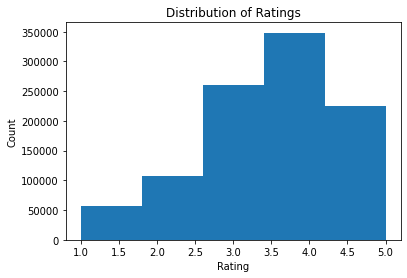

In [13]:
# Check the distribution of ratings
plt.hist(data['Rating'], bins=5)
plt.title("Distribution of Ratings")
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [14]:
data = data.drop(data[(data['Rating'] == 1) | (data['Rating'] == 2)].index)
data.shape

(834510, 4)

### 1-3. ItemId

- 일부 인기가 많은 영화가 존재하지만 골고루 분포하는 것으로 보임

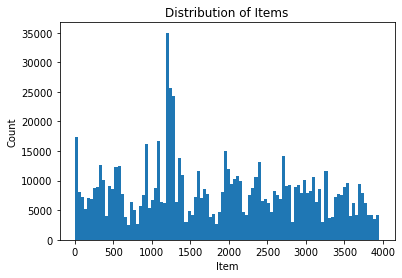

In [15]:
# Check the distribution of items
plt.hist(data['ItemId'], bins=100)
plt.title("Distribution of Items")
plt.xlabel('Item')
plt.ylabel('Count')
plt.show()

### 1-4. Time

- 해당 플랫폼은 2000년 5월부터 2021년 1월까지 사용이 활발했지만 
- 이후 2021년 2월부터는 급격히 사용이 줄었음 
- 따라서 사용이 활발했던 9개월 간의 정보만 사용

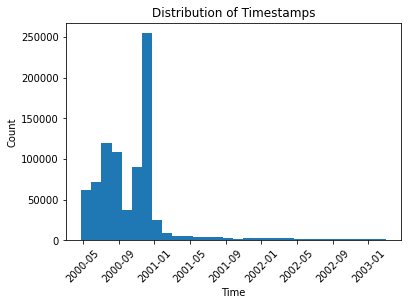

In [16]:
# Check the distribution of timestamps
plt.hist(data['Time'], bins=30)
plt.title("Distribution of Timestamps")
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

In [17]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [18]:
# Create a temporary column to extract the year and month
data['YearMonth'] = data['Time'].dt.to_period('M')
data

,UserId,ItemId,Rating,Time,YearMonth
31,1,3186,4,2000-12-31 22:00:19,2000-12
22,1,1270,5,2000-12-31 22:00:55,2000-12
27,1,1721,4,2000-12-31 22:00:55,2000-12
37,1,1022,5,2000-12-31 22:00:55,2000-12
24,1,2340,3,2000-12-31 22:01:43,2000-12
...,...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29,2001-08
999988,6040,1921,4,2001-08-10 14:41:04,2001-08
1000172,6040,1784,3,2001-08-10 14:41:04,2001-08
1000167,6040,161,3,2001-08-10 14:41:26,2001-08


In [19]:
# See the change in usage over the months
data['YearMonth'].value_counts().sort_values(ascending=False)

2000-11    241406
2000-08    151554
2000-12     94356
2000-07     77097
2000-05     56448
2000-06     45991
2000-09     44056
2000-10     35408
2001-01     15062
2000-04      9569
2001-02      6768
2001-03      5088
2001-04      4210
2001-06      4085
2001-05      4079
2001-07      3916
2001-08      3593
2001-12      2899
2002-01      2677
2001-09      2592
2001-11      2326
2002-04      2325
2002-02      2044
2002-03      1877
2001-10      1750
2002-08      1614
2002-11      1603
2002-05      1555
2002-07      1526
2003-01      1514
2002-06      1332
2003-02      1193
2002-09      1082
2002-12      1043
2002-10       872
Freq: M, Name: YearMonth, dtype: int64

In [20]:
# Keep the relevant months only 
data = data[(data['YearMonth'] == '2000-05') | 
            (data['YearMonth'] == '2000-06') | 
            (data['YearMonth'] == '2000-07') | 
            (data['YearMonth'] == '2000-08') |
            (data['YearMonth'] == '2000-09') |
            (data['YearMonth'] == '2000-10') |
            (data['YearMonth'] == '2000-11') |
            (data['YearMonth'] == '2000-12') |
            (data['YearMonth'] == '2001-01')]
data

,UserId,ItemId,Rating,Time,YearMonth
31,1,3186,4,2000-12-31 22:00:19,2000-12
22,1,1270,5,2000-12-31 22:00:55,2000-12
27,1,1721,4,2000-12-31 22:00:55,2000-12
37,1,1022,5,2000-12-31 22:00:55,2000-12
24,1,2340,3,2000-12-31 22:01:43,2000-12
...,...,...,...,...,...
1000075,6040,1273,4,2000-07-28 23:58:54,2000-07
1000188,6040,535,4,2000-07-28 23:58:54,2000-07
1000191,6040,3751,4,2000-07-28 23:59:42,2000-07
1000194,6040,1077,5,2000-07-28 23:59:59,2000-07


In [21]:
# Check the result 
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest)

2000-05-01 00:34:01
2001-01-31 22:11:05


In [22]:
# Drop the temporary column
data.drop(['YearMonth'], axis=1, inplace=True)

In [23]:
# Check for basic statistics
print(f"Number of unique users: {data['UserId'].nunique()}")
print(f"Number of unique movies: {data['ItemId'].nunique()}")
print(f"Rating distribution:\n{data['Rating'].value_counts()}")
print(f"Time range: {data['Time'].min()} to {data['Time'].max()}")
print(data.shape)

Number of unique users: 5973
Number of unique movies: 3588
Rating distribution:
4    316454
3    235422
5    209502
Name: Rating, dtype: int64
Time range: 2000-05-01 00:34:01 to 2001-01-31 22:11:05
(761378, 4)


### 2-4. cleaning

- 위에서 항목별로 이상치로 보이는 데이터나 불필요하다고 판단되는 데이터를 삭제했음
- 이 결과 얻어진 data를 기준으로 다시 데이터 확인
- 

In [24]:
films_per_user = data.groupby('UserId').size().reset_index(name='Films Watched')

films_per_user.min()[-1], films_per_user.median()[-1], films_per_user.mean()[-1], films_per_user.max()[-1]

(1, 76.0, 127.46994809978236, 1515)

In [25]:
films_per_user.sort_values(by='Films Watched').head(20)

,UserId,Films Watched
3031,3038,1
5969,6011,1
4477,4486,1
4458,4467,1
186,188,2
5966,6003,2
5957,5987,2
824,827,3
4264,4273,3
1543,1547,3


In [26]:
views_per_film = data.groupby('ItemId').size().reset_index(name='Views')

views_per_film.min()[-1], views_per_film.median()[-1], views_per_film.mean()[-1], views_per_film.max()[-1]

(1, 78.0, 212.20122630992196, 3091)

In [27]:
views_per_film.sort_values(by='Views').head(200)

,ItemId,Views
2863,3164,1
296,311,1
295,310,1
721,792,1
2761,3057,1
...,...,...
1496,1685,2
686,749,2
2569,2855,2
3148,3482,2


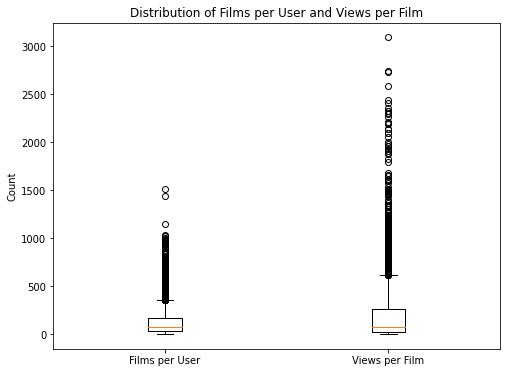

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Compute the data for users and films
films_per_user = data.groupby('UserId').size()
views_per_film = data.groupby('ItemId').size()

# Create a DataFrame combining both distributions
combined_data = pd.DataFrame({
    'Films per User': films_per_user,
    'Views per Film': views_per_film
})

# Plot the boxplot
plt.figure(figsize=(8, 6))
plt.boxplot([combined_data['Films per User'].dropna(), combined_data['Views per Film'].dropna()],
            labels=['Films per User', 'Views per Film'])

plt.title('Distribution of Films per User and Views per Film')
plt.ylabel('Count')
plt.show()


In [29]:
# least_view를 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, bad_taste, least_view) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_bad_taste_users_picks(data, bad_taste)
        data = cleanse_unpopular_films(data, least_view)
        after_len = len(data)
        if before_len == after_len:
            break
    return data

def cleanse_bad_taste_users_picks(data: pd.DataFrame, bad_taste):
    films_per_user = data.groupby('UserId').size()
    non_nightmare = films_per_user[films_per_user >= bad_taste].index
    data = data[data['UserId'].isin(non_nightmare)]
    return data

def cleanse_unpopular_films(data: pd.DataFrame, least_view):
    views_per_film = data.groupby('ItemId').size()
    not_unpopular = views_per_film[views_per_film >= least_view].index
    data = data[data['ItemId'].isin(not_unpopular)]
    return data

In [30]:
data = cleanse_recursive(data, bad_taste=5, least_view=2)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000075,6040,1273,4,2000-07-28 23:58:54
1000188,6040,535,4,2000-07-28 23:58:54
1000191,6040,3751,4,2000-07-28 23:59:42
1000194,6040,1077,5,2000-07-28 23:59:59


### 2-5. Train / Valid / Test split

In [31]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    user_last_time = data.groupby('UserId')['Time'].max().sort_values()
    user_in_train = data[data['Time'] < final_time - dt.timedelta(n_days)]
    user_in_test = data[data['Time'] >= final_time - dt.timedelta(n_days)]
    
    before_date = user_in_train
    after_date = user_in_test
    return before_date, after_date

In [32]:
tr, test = split_by_date(data, n_days=30)
tr, val = split_by_date(tr, n_days=30)

In [33]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [34]:
# Check the stats for each dataset
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 661201
	 Items: 3451
	 First Time : 2000-05-01 00:34:01
	 Last Time : 2000-12-02 22:10:14

* valid Set Stats Info
	 Events: 85497
	 Items: 3144
	 First Time : 2000-12-02 22:12:36
	 Last Time : 2001-01-01 22:10:38

* test Set Stats Info
	 Events: 14496
	 Items: 2460
	 First Time : 2001-01-01 22:15:10
	 Last Time : 2001-01-31 22:11:05



In [35]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id: index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [36]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## Step 2. 미니 배치의 구성

- 실습 코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
    - 단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

### 2-1. SessionDataset

In [37]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [38]:
# Apply new indices 
tr_dataset = SessionDataset(tr)
tr_dataset.df.tail(20)

,UserId,ItemId,Rating,Time,item_idx
999907,6040,3095,4,2000-07-10 23:22:23,516
1000110,6040,1699,3,2000-07-10 23:31:40,2027
1000059,6040,1249,4,2000-07-10 23:32:59,1113
1000130,6040,2300,5,2000-07-10 23:33:20,974
999903,6040,3083,4,2000-07-10 23:35:32,83
999943,6040,3819,5,2000-07-10 23:36:06,928
1000146,6040,2366,3,2000-07-10 23:36:06,818
999979,6040,1900,5,2000-07-28 23:52:32,2780
999955,6040,1188,4,2000-07-28 23:55:03,435
999981,6040,1912,3,2000-07-28 23:55:42,529


In [39]:
# Make sure the new indices have been tagged correctly
tr_dataset.df[tr_dataset.df['ItemId'] == 3095]

,UserId,ItemId,Rating,Time,item_idx
94122,631,3095,3,2000-12-02 17:57:25,516
94555,635,3095,5,2000-12-02 14:52:36,516
94845,637,3095,5,2000-12-02 05:46:23,516
95704,641,3095,4,2000-12-02 02:15:04,516
98108,656,3095,4,2000-12-01 18:52:59,516
...,...,...,...,...,...
982781,5934,3095,4,2000-05-01 22:03:11,516
983182,5939,3095,5,2000-05-01 20:28:02,516
983391,5942,3095,5,2000-05-01 18:46:25,516
985314,5954,3095,5,2000-05-07 12:30:32,516


In [40]:
tr_dataset.click_offsets

array([     0,      2,     86, ..., 661046, 661081, 661201], dtype=int32)

In [41]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 5335, 5336, 5337])

### 2-2. SessionDataLoader

In [42]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

            
    def initialize(self):
        # Ensure that the batch size does not exceed the number of sessions
        first_iters = np.arange(min(self.batch_size, len(self.dataset.session_idx)))  
        last_session = len(first_iters) - 1  # Last session should be based on actual number of available sessions

        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]  # Get start positions of sessions
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # Get end positions of sessions
        mask = np.array([])  # Placeholder for sessions that are finished
        finished = False  # Indicator to track if all sessions are processed
         
        return start, end, mask, last_session, finished
    
    
    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [43]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
92937,622,527,5,2000-12-02 22:08:26,0
92941,622,2028,4,2000-12-02 22:10:14,1
92947,623,2987,4,2000-12-02 21:23:14,2
93079,623,1968,4,2000-12-02 21:23:34,3
93095,623,1210,3,2000-12-02 21:24:08,4
92952,623,1259,4,2000-12-02 21:24:29,5
93049,623,111,5,2000-12-02 21:24:29,6
93025,623,3897,4,2000-12-02 21:25:11,7
93108,623,3910,4,2000-12-02 21:25:11,8
93109,623,3911,4,2000-12-02 21:25:11,9


In [44]:
iter_ex = iter(tr_data_loader)

In [45]:
inputs, labels, mask = next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0   2  85 179]
Label Item Idx are :       [  1   3  86 180]
Previous Masked Input Idx are []


## Step 3. 모델 구성

이 부분도 실습 코드 내역을 참고하여 다양하게 모델 구조를 시도해 볼 수 있습니다.

### 3-1. Evaluation Metric

In [46]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0
    
def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### 3-2. Model Architecture

In [47]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [48]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [49]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

In [50]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)
        pred = model.predict(input_ohe, batch_size=args.batch_size)
#         pred_arg = tf.nn.top_k(pred, k=124, sorted=True)[1]  # softmax 값이 큰 순서대로 sorting 합니다.
        pred_arg = tf.argsort(pred, direction='DESCENDING')
    
        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [51]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

## Step 4. 모델 학습

다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 
- 실습 코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

In [53]:
args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(256, 1, 3451)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    525450    
_________________________________________________________________
dropout_1 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (256, 3451)               176001    
Total params: 701,451
Trainable params: 701,451
Non-trainable params: 0
_________________________________________________________________


Evaluation:  74%|███████▎  | 242/329 [04:21<01:33,  1.08s/it]


	 - Recall@20 epoch 1: 0.147792
	 - MRR@20    epoch 1: 0.034630



Evaluation:  74%|███████▎  | 242/329 [04:04<01:27,  1.01s/it]


	 - Recall@20 epoch 2: 0.264866
	 - MRR@20    epoch 2: 0.066533



Evaluation:  74%|███████▎  | 242/329 [04:00<01:26,  1.01it/s]

	 - Recall@20 epoch 3: 0.294938
	 - MRR@20    epoch 3: 0.077323



## Step 5. 모델 테스트

미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

### Attempt 1

- batch_size=256 
- hsz=50
- drop_rate=0.1
- lr=0.001
- epochs=5
- k=20

In [54]:
test_model(model, args, test)

Evaluation:  20%|██        | 11/54 [00:11<00:45,  1.06s/it]

	 - Recall@20: 0.180753
	 - MRR@20: 0.046287



### Attempt 2: batch_size 조정 

- batch_size=128
- hsz=50
- drop_rate=0.1
- lr=0.001
- epochs=3
- k=20

In [55]:
args2 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)
model2 = create_model(args2)
train_model(model2, args2)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(128, 1, 3451)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    525450    
_________________________________________________________________
dropout_2 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_2 (Dense)              (128, 3451)               176001    
Total params: 701,451
Trainable params: 701,451
Non-trainable params: 0
_________________________________________________________________


Evaluation:  88%|████████▊ | 579/658 [05:14<00:42,  1.84it/s]


	 - Recall@20 epoch 1: 0.202855
	 - MRR@20    epoch 1: 0.050323



Evaluation:  88%|████████▊ | 579/658 [05:00<00:41,  1.92it/s]


	 - Recall@20 epoch 2: 0.280413
	 - MRR@20    epoch 2: 0.073315



Evaluation:  88%|████████▊ | 579/658 [04:56<00:40,  1.95it/s]

	 - Recall@20 epoch 3: 0.304202
	 - MRR@20    epoch 3: 0.082810



In [56]:
test_model(model2, args2, test)

Evaluation:  51%|█████▏    | 56/109 [00:29<00:28,  1.89it/s]

	 - Recall@20: 0.234515
	 - MRR@20: 0.061264



### Attempt 3: learning_rate 조정

- batch_size=256
- hsz=50
- drop_rate=0.1
- lr=0.0005
- epochs=3
- k=20

In [57]:
args3 = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.0005, epochs=3, k=20)
model3 = create_model(args3)
train_model(model3, args3)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(256, 1, 3451)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    525450    
_________________________________________________________________
dropout_3 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_3 (Dense)              (256, 3451)               176001    
Total params: 701,451
Trainable params: 701,451
Non-trainable params: 0
_________________________________________________________________


Evaluation:  74%|███████▎  | 242/329 [04:28<01:36,  1.11s/it]


	 - Recall@20 epoch 1: 0.090118
	 - MRR@20    epoch 1: 0.018141



Evaluation:  74%|███████▎  | 242/329 [04:21<01:33,  1.08s/it]


	 - Recall@20 epoch 2: 0.140996
	 - MRR@20    epoch 2: 0.032099



Evaluation:  74%|███████▎  | 242/329 [04:12<01:30,  1.04s/it]

	 - Recall@20 epoch 3: 0.200058
	 - MRR@20    epoch 3: 0.046856



In [58]:
test_model(model3, args3, test)

Evaluation:  20%|██        | 11/54 [00:12<00:47,  1.10s/it]

	 - Recall@20: 0.101207
	 - MRR@20: 0.020919



### Attempt 4: Model architecture 조정

GRU 1개층 추가

In [59]:
def create_model2(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [60]:
args4 = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)
model4 = create_model2(args4)
train_model(model4, args4)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(256, 1, 3451)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    525450    
_________________________________________________________________
dropout_5 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_4 (Dense)              (256, 3451)               176001    
Total params: 701,451
Trainable params: 701,451
Non-trainable params: 0
_________________________________________________________________


Evaluation:  74%|███████▎  | 242/329 [04:17<01:32,  1.07s/it]


	 - Recall@20 epoch 1: 0.154491
	 - MRR@20    epoch 1: 0.035938



Evaluation:  74%|███████▎  | 242/329 [04:02<01:27,  1.00s/it]


	 - Recall@20 epoch 2: 0.256457
	 - MRR@20    epoch 2: 0.066003



Evaluation:  74%|███████▎  | 242/329 [03:56<01:25,  1.02it/s]

	 - Recall@20 epoch 3: 0.294825
	 - MRR@20    epoch 3: 0.077839



In [61]:
test_model(model4, args4, test)

Evaluation:  20%|██        | 11/54 [00:11<00:44,  1.04s/it]

	 - Recall@20: 0.175426
	 - MRR@20: 0.049699



# 회고

- 처음에 SessionId 대신 어떤 것으로 기준을 잡아야 할지 많이 막막했는데, 다시 차근히 보니 이해가 조금 가기 시작했습니다. 데이터셋으로 돌아가 하나씩 자세히 뜯어보니 실마리가 보였던 것 같습니다. 
- Time이나 Ranking 등에서 한차례 추천에 도움이 될 것 같지 않거나 outlier로 판단되는 것들을 과감히 삭제했습니다. 
- 생각보다 훈련 시키는 데에 시간이 많이 들어, 이것 저것 실험해보는 게 엄두가 나지 않았습니다. 결국 epochs를 3으로 줄였습니다. (나는 오늘 잘 수 있을 것인가..)
- 전체적으로 플로우는 조금 이해가 가는 것 같지만 코드가 쉽지만은 않은 것 같습니다. 
- 결과: Recall과 MRR 모두 매우 낮은 성능을 보여줘 실망스러웠습니다. 추가적인 튜닝이 필요할 것으로 보입니다. 
    1. Attempt 2 (batch_size=128): Recall: 0.2345, MRR: 0.0613
        - 가장 높은 성능을 기록하며, Recall@20과 MRR@20 모두에서 가장 좋은 결과를 보였음. 
    2. Attempt 1 (batch_size=256): Recall: 0.1808, MRR: 0.0463
        - 초기 설정에서 평균적인 성능을 보였으며, Recall@20과 MRR@20이 중간 수준으로 측정됨. 
    3. Attempt 3 (learning_rate=0.0005): Recall: 0.1012, MRR: 0.0209
        -  학습률을 낮추었을 때 성능이 크게 저하됨. 특히 Recall@20과 MRR@20이 모두 급격히 떨어짐. 
    4. Attempt 4 (GRU 층 추가): Recall: 0.1754, MRR: 0.0497
        - 모델 구조를 복잡하게 했으나 성능 개선이 미미했으며, 기본 설정과 유사한 결과를 보임. 